### Dinkey Treatment Placement

The second chunk of the JFSP proposal as it related to Dinkey Creek Watershed indicates that we will take our No management simulations from the extreme fire weather scenario and use the mean fire severity to assign treatment placements. Further, we will not be doing any Thin Only simulations, it just doesn't make sense, as the first manuscript will indicate the potential for increased fire severity with thinning in the absence of RxFire. 


In [636]:
# Load required libraries and establish data directories

# ------- Notebook config
%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt

# ------- Load dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import gdal, os, osr

# ------- Working directory
dataDir = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/'
opconDir = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/TreatmentPlacement/'
idealizedsimNames = ['NoMgmtHistoricFireLowP', 'NoMgmtSevereFireLowP',
                    'ThinRxSevere_FV2']
opconsimNames = ['OperationalConstraint', 'HSFPriority']

#### Import some functions we developed earlier
Specifically, we're looking to work with the raster data from the previous simulations. We first pull them into a numpy list of gdal arrays (xxxStack), then we build a zstack with numpy's dstack() so that we can calculate the mean and variance of each pixel across replicates (xxxGen).

A bunch of other previously developed functions help chunk up the analysis into manageable bits. I need to make a class to simplify the code here in the near future ...

In [168]:
def centOutputGen(dataDir, simname):
    wkDir_reps =  dataDir + simname + '/'
    centFileName = 'Century-succession-log.csv'
    centFileNameM = 'Century-succession-monthly-log.csv'
    sppBioName = 'spp-biomass-log.csv'

    repnames = next(os.walk(wkDir_reps))[1]
    num_replicates = len(repnames)

    idx = 0
    for rep in repnames:
        repnum = rep.split('replicate')[1]
        wkDir_data = wkDir_reps + 'replicate' + repnum + '/'
        cent = pd.read_csv(wkDir_data + centFileName)
        cent['rep'] = int(repnum)
        centM = pd.read_csv(wkDir_data + centFileNameM)
        centM['rep'] = int(repnum)
        sppBio = pd.read_csv(wkDir_data + sppBioName)
        sppBio['rep'] = int(repnum)

        if idx == 0:
            centTot = cent
            centTotM = centM
            sppBioTot = sppBio

        else:
            centTot = pd.concat((centTot, cent))
            centTotM = pd.concat((centTotM, centM))
            sppBioTot = pd.concat((sppBioTot, sppBio))

        idx = idx + 1
    return centTot, centTotM, sppBioTot


def genCentWeightedMeansDF(aggregatedAnnualCentFile, simName):
    simCentDF = aggregatedAnnualCentFile
    # ------- Create new vars in Cent file and handle unit conversion ------- #
    simCentDF['TEC'] = (simCentDF['SOMTC'] + simCentDF['AGB']* 0.5 ) * 0.01 # Add total ecosystem carbon, Mg/ha
    simCentDF['AGBc'] = simCentDF['AGB']* 0.5 * 0.01 # Convert AGB from g /m^2 biomass to Mg/ha C
    simCentDF['NEEC'] = simCentDF['NEEC'] * -1 * 0.01 # Convert NEE sign convention 
    simCentDF['NECB'] = simCentDF['NEEC'] - (simCentDF['FireCEfflux'] * 0.01)
    activeArea = simCentDF.NumSites.unique().sum() # Calculate total sites in the simulation

    # ------- Generate mean and std of weighted ecoregion data ------- #
    simCentDF['TECw'] = simCentDF.TEC * (simCentDF.NumSites / activeArea)
    simCentDF['AGBw'] = simCentDF.AGBc * (simCentDF.NumSites / activeArea)
    simCentDF['NEECw'] = simCentDF.NEEC * (simCentDF.NumSites / activeArea)
    
    # Convert the fire efflux from g/m2 to Mg/ha (already in units of C), and 
    # produce the ecoregion weighted per hectare value
    simCentDF['FireCEffluxw'] = simCentDF.FireCEfflux * 0.01 * (simCentDF.NumSites / activeArea)
    simCentDF['NECBw'] = simCentDF['NEECw'] - simCentDF['FireCEffluxw']
    
    naiveMean = simCentDF.groupby(['EcoregionName','Time']).mean()
    naiveStd = simCentDF.groupby(['EcoregionName','Time']).std()
    
    # Generate a dataframe for that we can leverage when we want to ask questions
    # about the cumulative nature of some century variable, by replicate.
    naiveSum= simCentDF.groupby(['rep']).sum()

    naiveMean['NEECw_std'] = naiveStd.NEEC * (naiveMean.NumSites / activeArea) # 
    naiveMean['AGBw_std'] = naiveStd.AGBc * (naiveMean.NumSites / activeArea)
    naiveMean['TECw_std'] = naiveStd.TEC * (naiveMean.NumSites / activeArea)
    naiveMean['FireCEffluxw_std'] = naiveStd.FireCEfflux * (naiveMean.NumSites / activeArea)
    naiveMean['NECBw_std'] = naiveStd.NECBw * (naiveMean.NumSites / activeArea)
    resetMean = naiveMean.reset_index()
    resetSum = naiveSum.reset_index()
    
    # ------- Generate region-wide weighted mean of all ecoregions ------ #
    weightedMean = resetMean.groupby('Time').sum()  
    index = pd.date_range('2000-1-1', periods=len(weightedMean), freq='1A')
    weightedMean.index = index
    weightedMean[weightedMean.NEECw == 0] = np.nan
    weightedMean['Sim'] = simName
    resetSum['Sim'] = simName
    simCentDF['Sim'] = simName

    return weightedMean, simCentDF, resetSum

def severityStack(rasterLoc, runLength):
    rasterlist = []
    timesteps = np.linspace(1,runLength,runLength)
    
    repnames = next(os.walk(rasterLoc))[1]
    num_replicates = len(repnames)

    idx = 0
    for rep in repnames:
        counter = 0
        repnum = rep.split('replicate')[1]
        for time in timesteps:  
            wkDir_data = rasterLoc + '/' 'replicate' + repnum + '/' + 'fire/'
            sevmap = 'severity-' + str(int(time)) + '.img'
            src_ds = gdal.Open( wkDir_data + sevmap ) 
            sevarray = src_ds.ReadAsArray()
            sevarray = sevarray.astype('float')
            rasterlist.append(sevarray)            
    return rasterlist

def NEEStack(rasterLoc, runLength):
    rasterlist = []
    timesteps = np.linspace(1,runLength,runLength)
    
    repnames = next(os.walk(rasterLoc))[1]
    num_replicates = len(repnames)

    idx = 0
    for rep in repnames:
        counter = 0
        repnum = rep.split('replicate')[1]
        for time in timesteps:  
            wkDir_data = rasterLoc + '/' 'replicate' + repnum + '/century/'
            sevmap = 'nee-' + str(int(time)) + '.gis'
            src_ds = gdal.Open( wkDir_data + sevmap ) 
            sevarray = src_ds.ReadAsArray()
            sevarray = sevarray.astype('float')
            rasterlist.append(sevarray)           
    return rasterlist

def THINStack(rasterLoc, runLength):
    rasterlist = []
    thinlist = []
    rxfirelist = []
    timesteps = np.linspace(1,runLength,runLength)
    
    repnames = next(os.walk(rasterLoc))[1]
    num_replicates = len(repnames)

    idx = 0
    for rep in repnames:
        counter = 0
        repnum = rep.split('replicate')[1]
        for time in timesteps:  
            wkDir_data = rasterLoc + '/' 'replicate' + repnum + '/ThinMAP/'
            thinmap = 'biomass-removed-' + str(int(time)) + '.img'
            src_ds = gdal.Open( wkDir_data + thinmap ) 
            thinarray = src_ds.ReadAsArray()
            thinarray = thinarray.astype('float')
            rasterlist.append(thinarray)
            if time < 10:
                thinlist.append(thinarray)
            else:
                rxfirelist.append(thinarray)
            
    return rasterlist, thinlist, rxfirelist

def severityGen(rasterList):
    rasterStack = np.dstack(rasterList)  
    rasterAdj = rasterStack - 2
    rasterAdj[rasterAdj < 0] = np.nan
    meanSev = np.nanmean(rasterAdj, axis = 2)
    varSev = np.nanvar(rasterAdj, axis = 2)
    return meanSev, varSev

def NEEGen(rasterList):
    rasterStack = np.dstack(rasterList)
    rasterStack[rasterStack == 0] = np.nan
    rasterAdj = rasterStack - 1000
    cumNEE = np.nansum(rasterAdj, axis = 2)
    varNEE = np.nanvar(rasterAdj, axis = 2)
    return cumNEE, varNEE

def THINGen(rasterList):
    rasterStack = np.dstack(rasterList)
    countTHIN = np.count_nonzero(rasterStack, axis = 2)
    rasterStack[rasterStack == 0] = np.nan
    cumTHIN = np.nansum(rasterStack, axis = 2)
    varTHIN = np.nanvar(rasterStack, axis = 2)
    return countTHIN, cumTHIN, varTHIN

def genThinLog(simDir, simNames, tlogName):
    counter = 0
    for sim in simNames:        
        repnames = next(os.walk(simDir + sim))[1]
        num_replicates = len(repnames)
        print simDir + sim 
        for rep in repnames:
            thinDir = simDir + sim + '/' + rep + '/Thin/'
            if counter == 0:
                tlogTot = pd.read_csv(thinDir + tlogName)
                tlogTot['SIM'] = sim
                tlogTot['REP'] = rep
            else:           
                tlog = pd.read_csv(thinDir + tlogName)
                tlog['SIM'] = sim
                tlog['REP'] = rep
                tlogTot = pd.concat([tlogTot, tlog])
            counter = counter + 1
    return tlogTot

def saveAsGeoTiff(spatialRaster, ndarray, outputFileName, epsg):
    templatedf = gdal.Open(spatialRaster)
    template = templatedf.ReadAsArray()
    driver = gdal.GetDriverByName('GTiff')
    outputRaster = driver.Create(outputFileName,
                                 template.shape[1],
                                 template.shape[0],
                                 1, gdal.GDT_Int32)
    
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(epsg)
    dest_wkt = srs.ExportToWkt()
    
    outputRaster.SetGeoTransform(templatedf.GetGeoTransform())
    outputRaster.GetRasterBand(1).WriteArray(ndarray)
    outputRaster.SetProjection(dest_wkt)

    outputRaster.FlushCache()
    
def importRaster(rasterPath, **kwargs):
    # Open and read in the raster as an array
    raster_ds = gdal.Open(rasterPath)
    rastermap = raster_ds.ReadAsArray()
    
    # Set the default data type to 'float'
    if 'dtype' not in kwargs:
        dtype = 'float'
    rastermap = rastermap.astype(dtype)
    
    # If specified, set the no data value to NaN
    if 'noData' in kwargs:
        rastermap[rastermap == noData] = np.nan
    return rastermap

    
def plotRaster(image, ax=None, *args, **kwargs):

    # Grab figure axes if none stated
    if ax == None:
         ax = plt.gca()
                   
    # Normalize color scheme
    if 'norm' not in kwargs:
        vmin = kwargs.pop('vmin', None)
        vmax = kwargs.pop('vmax', None)
        if vmin is None:
            vmin = np.min(image) # or what ever
        if vmax is None:
            vmax = np.max(image)
        norm = matplotlib.colors.Normalize(vmin, vmax)
        kwargs['norm'] = norm

    #ax.figure.canvas.draw() # if you want to force a re-draw
    ax.imshow(image, *args, **kwargs)
    # Setup axes
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])


#### Read in the mean severity map for the No Action scenario
Leverage our previous work to create a mean severity raster from the previous Dinkey simulations. Were going to use this raster as the starting point from which to begin to designate treatment placements. For now we'll just display it.

In [5]:
sevMapsLowP = []
sevVarMapsLowP = []

for sim in idealizedsimNames:
    print dataDir + sim
    sevrasters = severityStack(dataDir + sim, 100)
    sevMap, sevVarMap = severityGen(sevrasters)
    sevmap = {sim : sevMap}
    sevVarmap = {sim : sevVarMap}

    sevMapsLowP.append(sevmap)
    sevVarMapsLowP.append(sevVarmap)


C:\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
C:\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/NoMgmtHistoricFireLowP
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/NoMgmtSevereFireLowP
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/ThinRxSevere_FV2


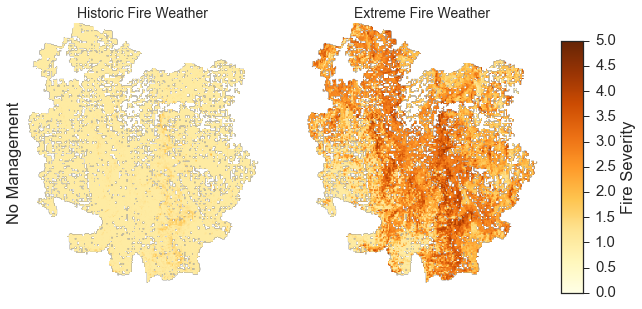

In [649]:
# Plot our hard earned severity raster
f,( ax1, ax2) = plt.subplots(1,2, figsize =(10,5))
plt.subplots_adjust(wspace = 0, hspace = 0.1)

sevMap = ax1.imshow(sevMapsLowP[0][idealizedsimNames[0]], cmap = 'YlOrBr', vmin = 0, vmax = 5)
sevMapS = ax2.imshow(sevMapsLowP[1][idealizedsimNames[1]], cmap = 'YlOrBr', vmin = 0, vmax = 5)

# Remove the axes
sns.despine()
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

# Add the color bar
cbar_ax = f.add_axes([0.90, 0.15, 0.03, 0.7])
f.colorbar(sevMap, cax=cbar_ax, label = 'Fire Severity')

# Labels
ax1.set_title('Historic Fire Weather', fontsize = 14)
ax2.set_title('Extreme Fire Weather', fontsize = 14)
ax1.set_ylabel('No Management')


sns.set_style('white')
sns.set_context('notebook',font_scale=1.5)

### Discretize the fire severity raster
We want to bin the fire severities in this raster into discrete groups, to make a thematic description of fire severity. I'll create a function to do this, so we can use it down the road -- we want to describe an arbitrary number of bins, and have control over bin size. For now we will keep bin sizes to 1.

In [7]:
def binRaster(rasterName):
    binnedRaster = np.zeros_like(rasterName)
    idx = 0
    binMin = 0
    binMax = 5
    bins = np.linspace(binMin,binMax,binMax + 1)
    for thisBin in bins:
        if thisBin < binMax:
            binnedRaster[(rasterName > thisBin) & (rasterName <= (thisBin + 1))] = thisBin + 1
    return binnedRaster

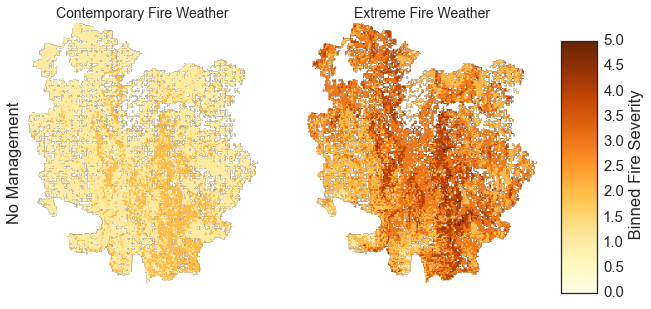

In [8]:
binnedSEV = binRaster(sevMapsLowP[0][idealizedsimNames[0]])
binnedSEVS = binRaster(sevMapsLowP[1][idealizedsimNames[1]])

binnedSEV[binnedSEV == 0] = np.nan
binnedSEVS[binnedSEVS == 0] = np.nan

# Plot our hard earned binned severity raster
f,( ax1, ax2) = plt.subplots(1,2, figsize =(10,5))
plt.subplots_adjust(wspace = 0, hspace = 0.1)

sevMap = ax1.imshow(binnedSEV, cmap = 'YlOrBr', vmin = 0, vmax = 5)
sevMapS = ax2.imshow(binnedSEVS, cmap = 'YlOrBr', vmin = 0, vmax = 5)

# Remove the axes
sns.despine()
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

# Add the color bar
cbar_ax = f.add_axes([0.90, 0.15, 0.05, 0.7])
f.colorbar(sevMap, cax=cbar_ax, label = ' Binned Fire Severity')

# Labels
ax1.set_title('Contemporary Fire Weather', fontsize = 14)
ax2.set_title('Extreme Fire Weather', fontsize = 14)
ax1.set_ylabel('No Management')


sns.set_style('white')
sns.set_context('notebook',font_scale=1.5)

#### It looks the exact same ... 
what the heck. Well, it makes sense actually, lets look for the difference between the two rasters for peace of mind. Actually, there is an increase in the severity of the Contemporary fire regime raster when we bin it, given that most of the severities are low. When we group everything from 0 - 1 as 1, and 1 - 2 as 2, were basically rounding all those low numbers up. We created 5 bins, so really the difference between the continuous raster and the binned raster should always be <= 1.0, a large difference in the case of the historic fire weather raster.

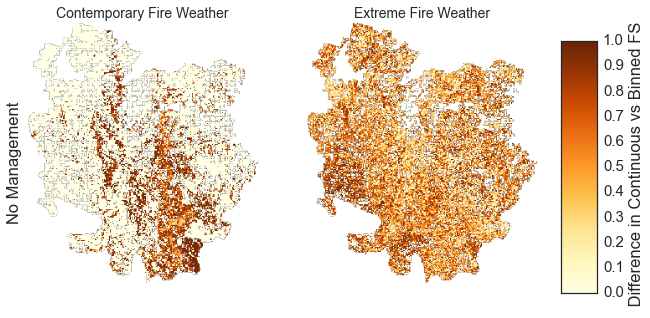

In [9]:
sevDiff = binnedSEV - sevMapsLowP[0][idealizedsimNames[0]]
sevDiffS = binnedSEVS - sevMapsLowP[1][idealizedsimNames[1]]

f,( ax1, ax2) = plt.subplots(1,2, figsize =(10,5))
plt.subplots_adjust(wspace = 0, hspace = 0.1)

sevMap = ax1.imshow(sevDiff, cmap = 'YlOrBr', vmin = 0, vmax = 1)
sevMapS = ax2.imshow(sevDiffS, cmap = 'YlOrBr', vmin = 0, vmax = 1)

# Remove the axes
sns.despine()
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

# Add the color bar
cbar_ax = f.add_axes([0.90, 0.15, 0.05, 0.7])
f.colorbar(sevMap, cax=cbar_ax, label = ' Difference in Continuous vs Binned FS')

# Labels
ax1.set_title('Contemporary Fire Weather', fontsize = 14)
ax2.set_title('Extreme Fire Weather', fontsize = 14)
ax1.set_ylabel('No Management')


sns.set_style('white')
sns.set_context('notebook',font_scale=1.5)

#### Looks good, we basically removed the decimals from our raster. 
Deos this even make sense to do? My first thought was just discretize the raster, and go from there... maybe a better way to approach it is to look at the distribution of fire severities across the watershed in our continuous raster, and pick from the distribution to create classes. Lets start with a histogram of severities.

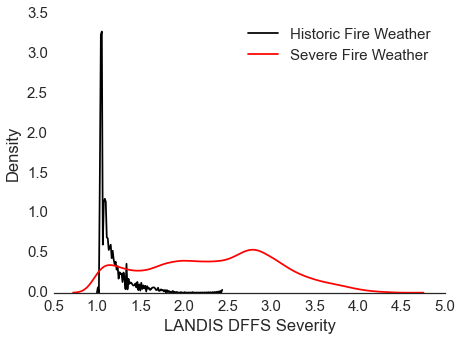

In [10]:
# Create a pandas dataframe out of the numpy array
sevdf = pd.DataFrame(dict(SEV = sevMapsLowP[0][idealizedsimNames[0]].ravel()))
sevdfS = pd.DataFrame(dict(SEV = sevMapsLowP[1][idealizedsimNames[1]].ravel()))

f, (ax1) = plt.subplots(1,1, figsize =(7,5))
sns.distplot(sevdf.SEV.dropna(), hist = False, color = 'k', ax = ax1, label='Historic Fire Weather')
sns.distplot(sevdfS.SEV.dropna(), hist = False, color = 'r', ax = ax1, label = 'Severe Fire Weather')

ax1.set_xlabel('LANDIS DFFS Severity')
ax1.set_ylabel('Density')
sns.despine(left=True)


#### Can we think of a better way to bin up severity...
Lets look at the cumulative distribution function (CDF) for our histogram of burn severities and see if we can't develop 3 bins based on the relative abundance of the mean severities across the watershed.

Since the cdf is just the probability density function (PDF) summed up over an ordered data set, we can just use a kernel density estimator to generate our PDF, and calculate the sum of that gaussian over our x-axis to get the CDF. With that function, we should be able to ask the question: 'At what mean fire severity are we going to capture X% of our observations?

In [11]:
# The kernel operators here take a bit of time, so I'll generate the DF in a separate
# cell, and plot the results below.

from scipy import optimize, stats # Using Scipy here for the kernel operator bits. Not using
                                  # Optimize at all, but if we want to fit gaussians to our data,
                                  # that's how Id go about doing it.  

kernel = stats.gaussian_kde(sevdf.SEV.dropna())
kernelS = stats.gaussian_kde(sevdfS.SEV.dropna())

yy = kernel(sevdf.SEV)
xx = sevdf.SEV

yyS = kernelS(sevdfS.SEV)
xxS = sevdfS.SEV

sevData = pd.DataFrame(dict(severities = xx, density = yy))
sevDataS = pd.DataFrame(dict(severities = xxS, density = yyS))

#### We need to sort our PDF data by severity, our index
that way when we create our cumulative curve, we will have a nice smooth plot

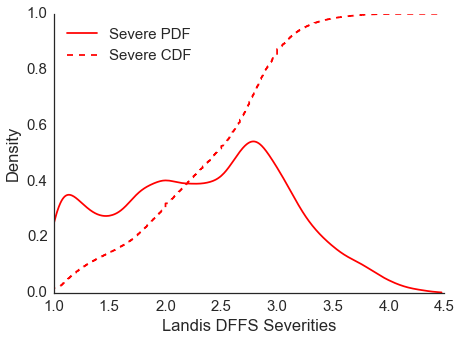

In [12]:
sortedDF = sevData.sort_values('severities').dropna()
sortedDFS = sevDataS.sort_values('severities').dropna()


f, ax = plt.subplots(1,1, figsize =(7,5))

# Here, we need to normalize the PDF data such that once we integrate over the 
# sorted index (severity), we will sum to unity. Thats what the sortedDF.density.sum() call is for.
#ax.plot(sortedDF.severities, sortedDF.density, '-k', label='Historic PDF')
#ax.plot(sortedDF.severities, sortedDF.density.cumsum()/sortedDF.density.sum(), '--k', label='Historic CDF')

ax.plot(sortedDFS.severities, sortedDFS.density, '-r', label='Severe PDF')
ax.plot(sortedDFS.severities, sortedDFS.density.cumsum()/sortedDFS.density.sum(), '--r', label='Severe CDF')

# For the sake of future me, lets make a column withour CDF data
sortedDF['CDF'] = sortedDF.density.cumsum()/sortedDF.density.sum()
sortedDFS['CDF'] = sortedDFS.density.cumsum()/sortedDFS.density.sum()

ax.legend(loc='best')
ax.set_xlabel('Landis DFFS Severities')
ax.set_ylabel('Density')
sns.despine()

### Alright, now we can get at our driving question here:
##### What % of the landscape are we talking about when we look at mean severity in each of our bins?
Are those severity bins reasonable? Our dope ass pie chart suggests no.. lets calculate those percentages using the CDF to pass the laugh test, then start asking some more of our data set. I'm beginning to think that MEAN Severity in this case might be bullshit, and that we should pull in all of the continuous fire data, make a giant stack, and produce a histogram of per pixel actual fire severities. Lets see if we can avoid doing that, for the sake of computation time.

In [13]:
print sortedDFS.severities[sortedDFS.CDF >= 0.35].iloc[0]
print sortedDFS.severities[sortedDFS.CDF >= 0.9993].iloc[0]
print sortedDFS.severities[sortedDFS.CDF >= 0.9995].iloc[0]

2.09090909091
3.96428571429
4.0


#### So, these bins are pretty skewed, which is alright..
But maybe we should try and get a little more quantititative. If we ask 'What percentile of our distribution are severities >= 3.5?' we can see its actually a tiny chunk... were in the 98th percentile, and only dealing with 5.5% of the landscape, or 2515 acres.

In [14]:
print sortedDFS[sortedDFS.severities > 3.5].count() 
print sortedDFS[sortedDFS.severities > 3.5].iloc[0]
print sortedDFS[sortedDFS.severities > 3.5].count()/45256 * 100

density       2515
severities    2515
CDF           2515
dtype: int64
density       0.163120
severities    3.511111
CDF           0.984677
Name: 43451, dtype: float64
density       5.557274
severities    5.557274
CDF           5.557274
dtype: float64


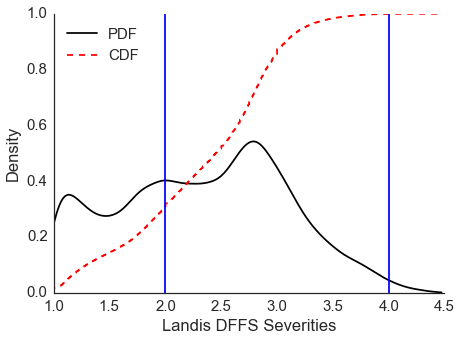

In [15]:
f, ax = plt.subplots(1,1, figsize =(7,5))

# Here, we need to normalize the PDF data such that once we integrate over the 
# sorted index (severity), we will sum to unity. Thats what the sortedDF.density.sum() call is for.
ax.plot(sortedDFS.severities, sortedDFS.density, '-k', label='PDF')
ax.plot(sortedDFS.severities, sortedDFS.density.cumsum()/sortedDFS.density.sum(), '--r', label='CDF')

ax.axvline(2)
ax.axvline(4)

#sortedDF[sortedDF.severities > 3.5]

ax.legend(loc='best')
ax.set_xlabel('Landis DFFS Severities')
ax.set_ylabel('Density')
sns.despine()

plt.savefig('MeanSeverityPDF_CDF.tif')

### Mean severity is a tricky beast
And I don't think its going to cut it. I wanted to avoid building burn probabilities for each grid cell in the simulation using the 5,000 rasters involved, but a recent chat with Matt arrived at the same conclusion. So, the plan is to build a probability of high severity (4-5) raster, by calculating the fraction of burned at high severity / number of fires per pixel.

Step 1, generate the raster stack. Leverage the previously written function here to do so, slightly modified to produce additional outputs.

In [16]:
def severityPGen(rasterList):   
    # Stack the rasters
    rasterStack = np.dstack(rasterList)
    
    # Adjust fire severity by -2 (scale it to 1-5)
    rasterAdj = rasterStack - 2
    
    # Make all resulting negatives = NaN
    rasterAdj[rasterAdj < 0] = np.nan
    
    # Calculate the mean and variance of the stack
    # along axis 2 (the z axis)
    meanSev = np.nanmean(rasterAdj, axis = 2)
    varSev = np.nanvar(rasterAdj, axis = 2)

    # Create a raster layer to count the number of fires.
    fireMask = rasterStack - 2
    fireMask[fireMask <= 0] = np.nan

    # Here, we take each fire raster and assign
    # all fires with severity >= 1 a value of 1.
    fireMask[fireMask > 0] = 1

    # Tally them up, reset no data value
    totalFires = np.nansum(fireMask, axis = 2)
    totalFires[totalFires == 0] = np.nan

    # Now only count fires with severity >= 4 (High Severity)
    HSMask = rasterStack - 5
    HSMask[HSMask <= 0] = np.nan
    HSMask[HSMask > 0] = 1
    totalHSFires = np.nansum(HSMask, axis = 2)
    totalHSFires[totalHSFires ==0] = np.nan

    # Calculate the probability of high severity fire as the count of HS / count of Total Fires
    pHS_Fires = totalHSFires / totalFires
    
    return meanSev, varSev, totalFires, totalHSFires, pHS_Fires

#### Iterate over the severity raster data
and generate stacks of the probability of fire rasters. Because we are producing so many stacks of rasters in this case, the process takes a bit of time.

In [700]:
sevMapsLowP = []
sevVarMapsLowP = []
totalFireMaps = []
totalHSFireMaps = []
pHS_FireMaps = []

for sim in idealizedsimNames:
    print dataDir + sim
    sevrasters = severityStack(dataDir + sim, 100)
    meansev, varsev, totalFires, totalHSFires, pHS_Fire = severityPGen(sevrasters)    
    sevmap = {sim : meansev}
    varmap = {sim : varsev}
    tfires = {sim : totalFires}
    thsfires = {sim : totalHSFires}
    hsfirep = {sim : pHS_Fire}

    sevMapsLowP.append(sevmap)
    sevVarMapsLowP.append(varmap)
    totalFireMaps.append(tfires)
    totalHSFireMaps.append(thsfires)
    pHS_FireMaps.append(hsfirep)


Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/NoMgmtHistoricFireLowP
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/NoMgmtSevereFireLowP
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/ThinRxSevere_FV2


#### Now that we have the data we can look at how the progression
of how fire density, to severe fire density, can be exploited to tell us where severe fires are most probably on the landscape. Really we can answer the question 'What is the probability that X area will experience high severity fire in the next X years' which is a great way to constrain treatment placement.

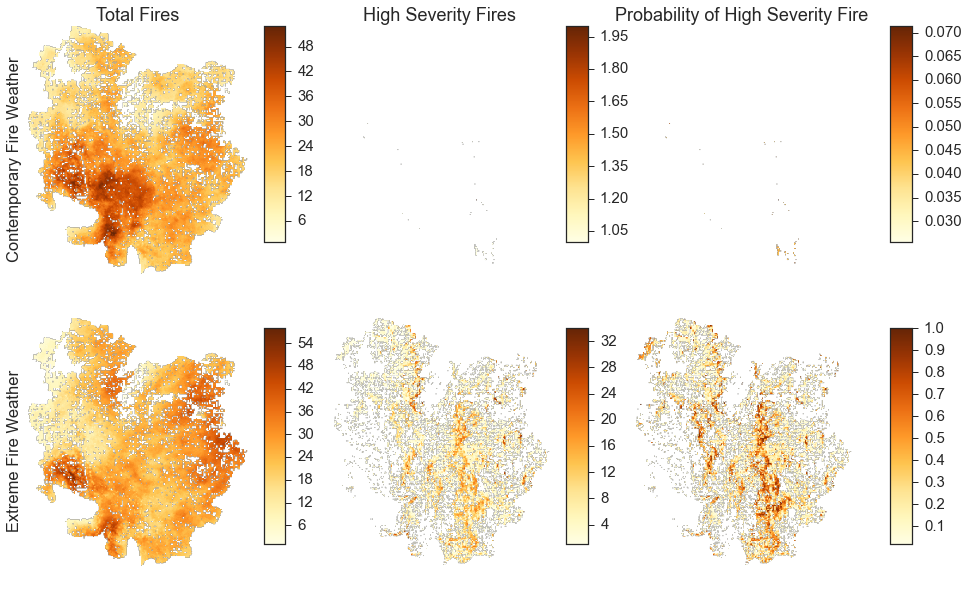

In [701]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize =(15,10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.1)
firesTotal = ax1.imshow(totalFireMaps[0][idealizedsimNames[0]], cmap = 'YlOrBr')
HSfiresTotal = ax2.imshow(totalHSFireMaps[0][idealizedsimNames[0]], cmap = 'YlOrBr')
HSFire_Probability = ax3.imshow(pHS_FireMaps[0][idealizedsimNames[0]], cmap = 'YlOrBr')

firesTotalS = ax4.imshow(totalFireMaps[1][idealizedsimNames[1]], cmap = 'YlOrBr')
HSfiresTotalS = ax5.imshow(totalHSFireMaps[1][idealizedsimNames[1]], cmap = 'YlOrBr')
HSFire_ProbabilityS = ax6.imshow(pHS_FireMaps[1][idealizedsimNames[1]], cmap = 'YlOrBr')




# Remove the axes
sns.despine()
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

# Add the color bars
cbar_ax1 = f.add_axes([0.35, 0.60, 0.02, 0.3])
f.colorbar(firesTotal, cax=cbar_ax1)

cbar_ax2 = f.add_axes([0.63, 0.60, 0.02, 0.3])
f.colorbar(HSfiresTotal, cax=cbar_ax2)

cbar_ax3 = f.add_axes([0.93, 0.60, 0.02, 0.3])
f.colorbar(HSFire_Probability, cax=cbar_ax3)

cbar_ax4 = f.add_axes([0.35, 0.18, 0.02, 0.3])
f.colorbar(firesTotalS, cax=cbar_ax4)

cbar_ax5 = f.add_axes([0.63, 0.18, 0.02, 0.3])
f.colorbar(HSfiresTotalS, cax=cbar_ax5)

cbar_ax6 = f.add_axes([0.93, 0.18, 0.02, 0.3])
f.colorbar(HSFire_ProbabilityS, cax=cbar_ax6)


ax1.set_title('Total Fires')
ax2.set_title('High Severity Fires')
ax3.set_title('Probability of High Severity Fire')
ax1.set_ylabel('Contemporary Fire Weather')
ax4.set_ylabel('Extreme Fire Weather')

sns.set_style('white')
sns.set_context('notebook',font_scale=1.5)
plt.savefig('FireCountsAndProbability.tif')

### Now we need to generate managment units for new LANDIS runs
We have these probability surfaces generated, and basically now we need to create an input to LANDIS that will inform management (thinning, and prescribed fire). We need to cut up these areas based on the previous management units, which were essentially dominant forest types. By creating a mask for areas to treat, maybe based on some arbitrary probability of severe fire, we can do some geospatial joining of management unit. Really, just raster math should suffice.

First things first, we want to run the 'Idealized' version of the previous Dinkey work, but constraining area available for treatment by slope. Anything greater than 30 degrees slope will be removed from the operational range. Handling this in the Leaf Biomass Harvest extension is a bit of a pain. I think the best way to go about it is to have separate, overlapping management units for thinning and RxFire. The thinning management units will simply have inactive cells where slope exceeds the threshold. The RxFire units will be active everywhere, and when the harvest step rolls around, LANDIS will handle inactive simulation cells accordingly, and burn everywhere else. We'll see how that pans out.

#### Modify the old management unit layer
We can keep everything with the management units the same for the RxFire treatments, but for thinning, we need to read in and assign inactive values to cells above a specific slope. Lets take a look at the terrain and get a few numbers out of the process for later -- like what percent of the land we are removing from thinning, by management unit, etc.

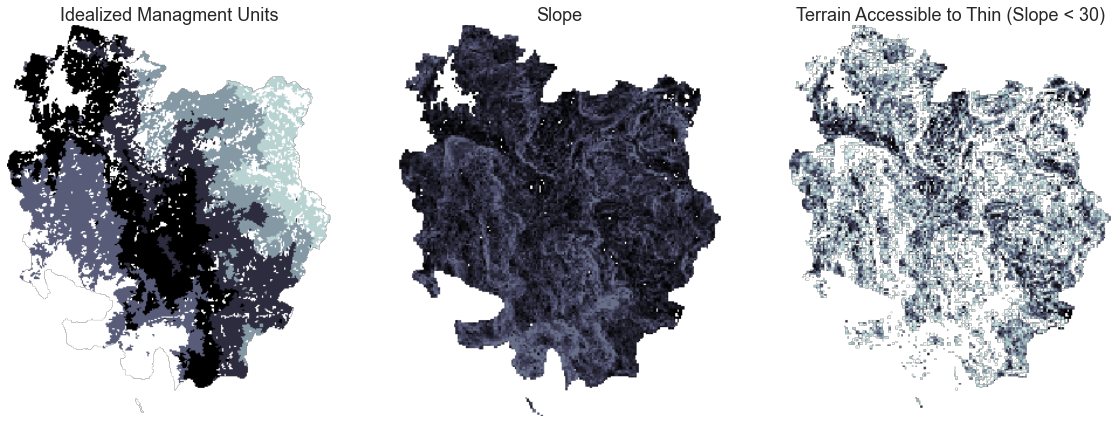

In [19]:
# Read in the management unit raster and the slope raster
mgmtUnit = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/MgmtRedux.tif'
dinkeySlope = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/DinkeySlope.tif'

mgmt_ds = gdal.Open( mgmtUnit )
slope_ds = gdal.Open( dinkeySlope )

mgmtmap = mgmt_ds.ReadAsArray()
mgmtmap = mgmtmap.astype('float')
mgmtmap[mgmtmap == 0] = np.nan

slopemap = slope_ds.ReadAsArray()
slopemap = slopemap.astype('float')

# Create a version of the slope map where all values over 30 degrees
# are set to NaN
highslope = slope_ds.ReadAsArray()
highslope = highslope.astype('float')
highslope[highslope > 30] = np.nan

# Create the figure and show the three maps
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize =(21,7))
plt.subplots_adjust(hspace = 0, wspace = 0)
ax1.imshow(mgmtmap, cmap = 'bone')
ax2.imshow(slopemap, cmap = 'bone')
ax3.imshow(highslope, cmap = 'bone')

ax1.set_title('Idealized Managment Units')
ax2.set_title('Slope')
ax3.set_title('Terrain Accessible to Thin (Slope < 30)')

sns.despine(left = True, bottom = True)
for ax in f.axes:
    ax.set_xticklabels('')
    ax.set_yticklabels('')



#### Turn the slope < 30 raster into a mask
and multiply it by the management unit raster to get the resulting constrained management units.

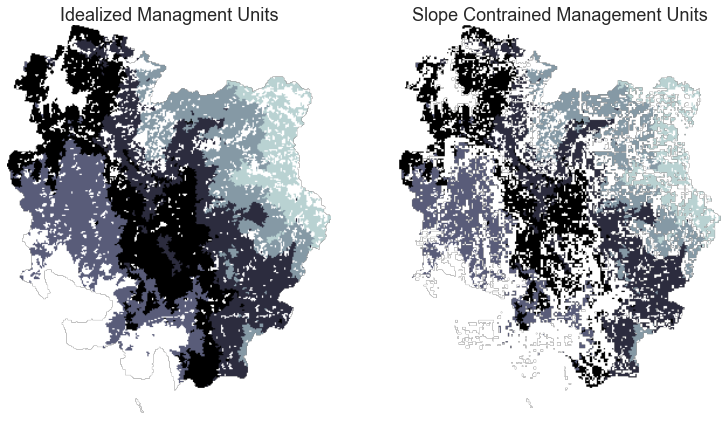

In [20]:
# Divide the high slope raster by itself to turn it into a binary mask
# and retain the NaN values
highslope = highslope / highslope

# Apply it to the management unit raster
constMgmt = mgmtmap * highslope

# Plot the result
f, (ax1, ax2) = plt.subplots(1,2, figsize =(14,7))
plt.subplots_adjust(hspace = 0, wspace = 0)
ax1.imshow(mgmtmap, cmap = 'bone')
ax2.imshow(constMgmt, cmap = 'bone')

ax1.set_title('Idealized Managment Units')
ax2.set_title('Slope Contrained Management Units')

sns.despine(left = True, bottom = True)
for ax in f.axes:
    ax.set_xticklabels('')
    ax.set_yticklabels('')

#### What does this mean in terms of the % area by management unit
that can no longer be mechanically thinned?

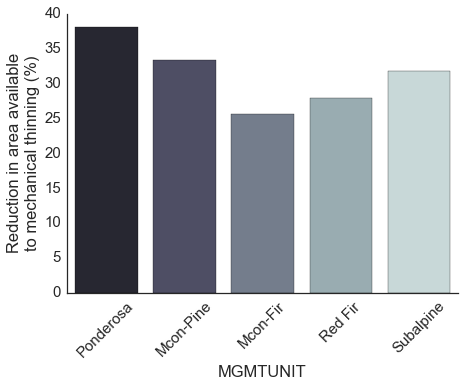

In [21]:
# Count the % loss of each management unit in terms 
# of what can no longer be mechanically thinned
mgmtarea = []
constarea = []
mgmtunits = np.unique(mgmtmap[~np.isnan(mgmtmap)])
for unit in mgmtunits:
    constarea.append(constMgmt[constMgmt == unit].sum()) 
    mgmtarea.append(mgmtmap[mgmtmap == unit].sum())

# Create a df for plotting and shit
mgmtReduc = pd.DataFrame(dict(MGMTUNIT = mgmtunits, IDEAL = mgmtarea, 
                              SLOPECON = constarea))

# Create a percent reduction column
mgmtReduc['REDUC'] = (1 - (mgmtReduc.SLOPECON / mgmtReduc.IDEAL)) * 100

f, ax = plt.subplots(1,1, figsize =(7,5))
sns.barplot(x = 'MGMTUNIT', y = 'REDUC', data = mgmtReduc, order=[3,1,2,4,5],
           palette = 'bone')
ax.set_ylabel('Reduction in area available \nto mechanical thinning (%)')
ax.set_xticklabels(['Ponderosa','Mcon-Pine','Mcon-Fir',
                    'Red Fir','Subalpine'], rotation = 45)
sns.despine()

#### Now we just need to create a second set of management units
since no one grid cell in the LANDIS landscape can belong to two management units, we need to describe on set of the landscape that will be thinned and burned (our operational contraint management unit raster) and one that will only be burned (the area that was removed, or slope > 30).

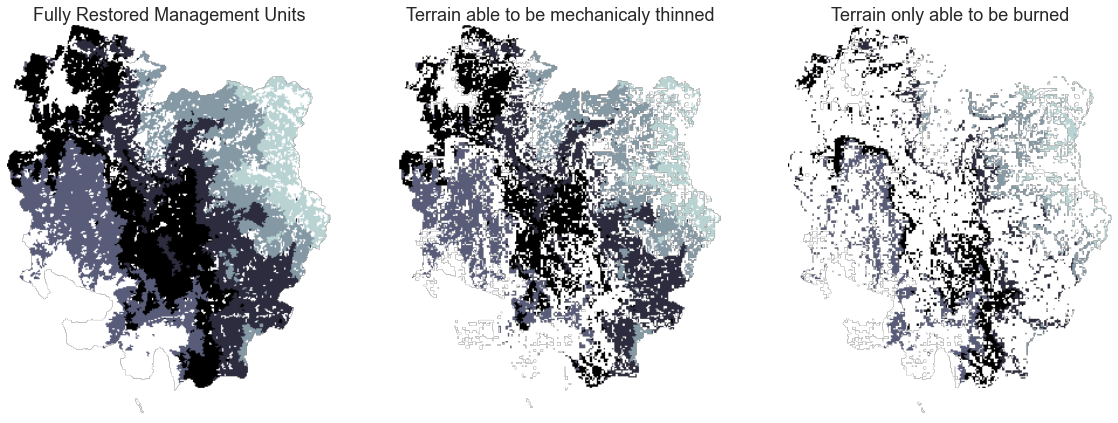

In [22]:
lowslope = slope_ds.ReadAsArray()
lowslope = lowslope.astype('float')
lowslope[lowslope <= 30] = np.nan

# Divide the high slope raster by itself to turn it into a binary mask
# and retain the NaN values
lowslope = lowslope / lowslope

# Apply it to the management unit raster
rxonlyMgmt = mgmtmap * lowslope

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize =(21,7))
plt.subplots_adjust(hspace = 0, wspace = 0)
ax1.imshow(mgmtmap, cmap = 'bone')
ax2.imshow(constMgmt, cmap = 'bone')
ax3.imshow(rxonlyMgmt, cmap = 'bone')

ax1.set_title('Fully Restored Management Units')
ax2.set_title('Terrain able to be mechanicaly thinned')
ax3.set_title('Terrain only able to be burned')

sns.despine(left = True, bottom = True)
for ax in f.axes:
    ax.set_xticklabels('')
    ax.set_yticklabels('')


#### We have the rasters we need to make moves on the getting the first runs going
However, we need to produce an actual Tif file for LANDIS, which for some reason can be kinda of a pain in the ass. We need to make sure we export the file in the apropriate format etc. We can grab a previously created function to do this, based on the idea that if we have something that we know works, we can use it as a template of sorts to produce a tif.

Also, we need to create Unique raster values for our RxFire only raster (slope > 30), so we can include them as different management units in the leaf biomass harvest extension (thin logs).

In [23]:
# Lets fix the management unit assignments first. 
# Adding 10 to each of them might make it simple.
rxOnlyMgmt = rxonlyMgmt + 10

# Now double check shit before we export
print 'Thin and RxFire  management unit numbers are: ' + \
    str(np.unique(mgmtmap[~np.isnan(mgmtmap)]))
    
print 'RxFire only management unit numbers are: ' + \
    str(np.unique(rxOnlyMgmt[~np.isnan(rxOnlyMgmt)]))

Thin and RxFire  management unit numbers are: [ 1.  2.  3.  4.  5.  6.]
RxFire only management unit numbers are: [ 11.  12.  13.  14.  15.  16.]


#### Now we just add them together
to produce the new management raster for the operationally constrained runs

New oper constrained mgmt unit numbers are: [  0.   1.   2.   3.   4.   5.   6.  11.  12.  13.  14.  15.  16.]


[]

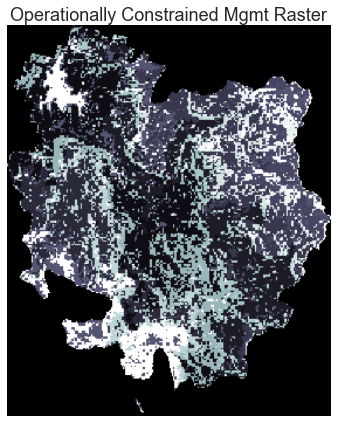

In [24]:
# First we need to convert all NaN values to 0 for both rasters
constMgmt[np.isnan(constMgmt)] = 0
rxOnlyMgmt[np.isnan(rxOnlyMgmt)] = 0
operMgmt = constMgmt + rxOnlyMgmt

# and make sure that we got what we expect
print 'New oper constrained mgmt unit numbers are: ' + \
    str(np.unique(operMgmt[~np.isnan(operMgmt)]))
    
# Plot it for shits
f, ax = plt.subplots(1,1, figsize =(7,7))
ax.imshow(operMgmt, cmap = 'bone')

ax.set_title('Operationally Constrained Mgmt Raster')

sns.despine(left = True, bottom = True)
ax.set_xticklabels('')
ax.set_yticklabels('')

#### This looks great
We have no NaN values here, all inactive grid cells are Zeroes. There's a bit of frass around, for instance the 6th management unit originally was all of the land we just didn't ever simulate -- either water or bare rock etc -- but now we have a 16th management unit, thats basically un-simulated terrain that too steep to mechanically thin! I don't really care, but there it is. If for some reason it causes problems down the road ...

In [25]:
# Export the map in the same format, shape, projection etc as the original
saveAsGeoTiff('Z:/Dan K/DinkeyCreek/LANDIS_RUNS/MgmtRedux.tif', 
              operMgmt, 'Z:\Dan K\DinkeyCreek\LANDIS_RUNS\OpConMgmt.tif', 5070)

#### The last step is to modify the thinning prescription
to accomodate the change in management units. If we take a look at the old thin and burn prescription below:
<img src="thinandburn_prescip.JPG" width="600")>
we can see that of the 6 management units, only 4 really have prescripts, and only 3 of those get any mechanical thinning.

Our new approach to management here is to apply thinning and rxfire to old management units, and then rxfire only to the new management units. This actually makes the new thinning and burning prescription pretty sensible:
<img src="thinandburn_opcon_prescip.JPG" width="625")>


#### Check out the initial output 
from the operational constraints simulations. Start with C dynamics - AGC, TEC, NEE, NECB

In [691]:
opconCent, opconCent_m, opconsppBio = centOutputGen(opconDir, opconsimNames[0])
HSFPCent, HSFPCent_m, HSFPCentsppBio = centOutputGen(opconDir, opconsimNames[1])

idealS, idealS_m, idealsbbBio = centOutputGen(dataDir, idealizedsimNames[1])
idealSTRx, idealSTRx_m, idealSTRxsppbio = centOutputGen(dataDir, idealizedsimNames[2])

opconWeight, opconUnWeight, opconSum = genCentWeightedMeansDF(opconCent,'Opcon')
HSFPWeight, HSFPUnWeight, HSFPSum = genCentWeightedMeansDF(HSFPCent,'HSFPriority')

weightedSWF, simCentCSWF, summedSWF = genCentWeightedMeansDF(idealS, 'No Mgmt SWF')
weightedSWFTRx, simCentCSWFTRx, summedSWFTRx = genCentWeightedMeansDF(idealSTRx, 'ThinningRx SWF')

totSims = pd.concat([HSFPWeight, opconWeight, weightedSWF, weightedSWFTRx])
totSums = pd.concat([HSFPSum, opconSum, summedSWF, summedSWFTRx])

HSFPriority
Opcon
ThinningRx SWF
HSFPriority
Opcon
ThinningRx SWF
HSFPriority
Opcon
ThinningRx SWF


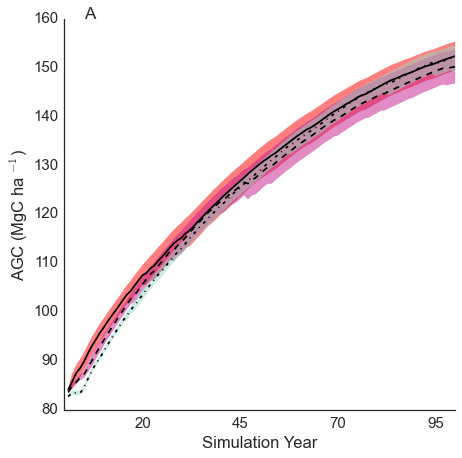

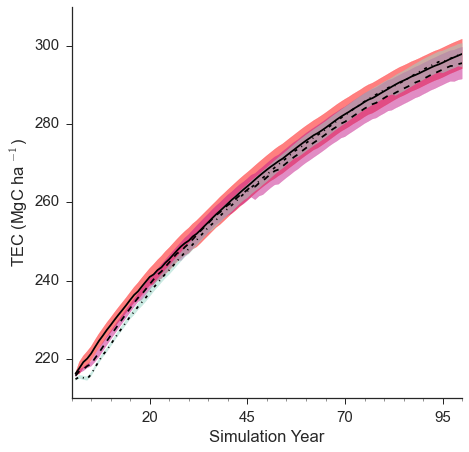

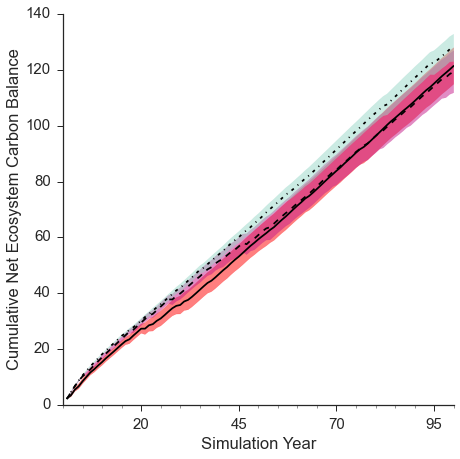

In [760]:
sns.set_context('notebook', font_scale=1.5)

Sims = ['HSFPriority', 'Opcon','ThinningRx SWF']
simColors = ['red','#c51b8a','#99d8c9']
simStyles = ['-','--','-.']

f, (ax) = plt.subplots(1,1, figsize =(7,7))
plt.subplots_adjust(wspace = 0.3)
simidx = 0
for sim in Sims:
    print sim
    simMean = totSims[totSims.Sim == sim]
    simMean.AGBw.plot(ax = ax, color = 'black', linestyle = simStyles[simidx])
    ax.fill_between(simMean.index, 
                 simMean.AGBw+3*simMean.AGBw_std/np.sqrt(50), 
                 simMean.AGBw-3*simMean.AGBw_std/np.sqrt(50), 
                 alpha = 0.5, color = simColors[simidx])
    simidx = simidx + 1 
    ax.set_xticklabels([20,45,70,95])


ax.set_xlabel('Simulation Year')
ax.set_ylabel('AGC (MgC ha $^{-1}$)')
ax.text(0.05, 1, 'A', transform=ax.transAxes, fontsize=17)

sns.despine()
sns.set_style('ticks')
plt.savefig('opcon_AGC.tif')


### HISTORIC FIRE WEATHER TEC -------------------------------


f, (ax) = plt.subplots(1,1, figsize =(7,7))
plt.subplots_adjust(wspace = 0.3)
simidx = 0
for sim in Sims:
    print sim
    simMean = totSims[totSims.Sim == sim]
    simMean.TECw.plot(ax = ax, color = 'black', linestyle = simStyles[simidx])
    ax.fill_between(simMean.index, 
                 simMean.TECw+3*simMean.TECw_std/np.sqrt(50), 
                 simMean.TECw-3*simMean.TECw_std/np.sqrt(50), 
                 alpha = 0.5, color = simColors[simidx])
    simidx = simidx + 1 
    ax.set_xticklabels([20,45,70,95])

ax.set_ylim([210, 310])
ax.set_xlabel('Simulation Year')
ax.set_ylabel('TEC (MgC ha $^{-1}$)')

sns.despine()
sns.set_style('ticks')
plt.savefig('opcon_TEC.tif')





### SEVERE FIRE WEATHER NECB -------------------------------


f, (ax) = plt.subplots(1,1, figsize =(7,7))
plt.subplots_adjust(wspace = 0.3)
simidx = 0
for sim in Sims:
    print sim
    simMean = totSims[totSims.Sim == sim]
    simMean.NECBw.cumsum().plot(ax = ax, color = 'black', linestyle = simStyles[simidx])
    ax.fill_between(simMean.index, 
                 simMean.NECBw.cumsum()+3*simMean.NECBw_std.cumsum()/np.sqrt(50), 
                 simMean.NECBw.cumsum()-3*simMean.NECBw_std.cumsum()/np.sqrt(50), 
                 alpha = 0.5, color = simColors[simidx])
    simidx = simidx + 1
    ax.set_xticklabels([20,45,70,95])


ax.set_xlabel('Simulation Year')
ax.set_ylabel('Cumulative Net Ecosystem Carbon Balance')

sns.despine()
sns.set_style('ticks')
plt.savefig('opcon_NECB.tif')

#### Now scope the burn severity. 
Like before, we will plot the severe FW No management, and severe FW full restoration (thin and burn) from the previous work for context. First read in the new opcon burn sev and CV rasters, then plot everything together.

In [703]:
# We already have the idealized burn severity rasters read in,
# so we just have to add the opcon rasters as well.
opconBurnSev = []
opconBurnCV = []

for sim in opconsimNames:
    print opconDir + sim
    sevrasters = severityStack(opconDir + sim, 100)
    sevMap, sevVarMap = severityGen(sevrasters)
    sevmap = {sim : sevMap}
    sevVarmap = {sim : sevVarMap}

    opconBurnSev.append(sevmap)
    opconBurnCV.append(sevVarmap)

Z:/Dan K/DinkeyCreek/LANDIS_RUNS/TreatmentPlacement/OperationalConstraint
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/TreatmentPlacement/HSFPriority


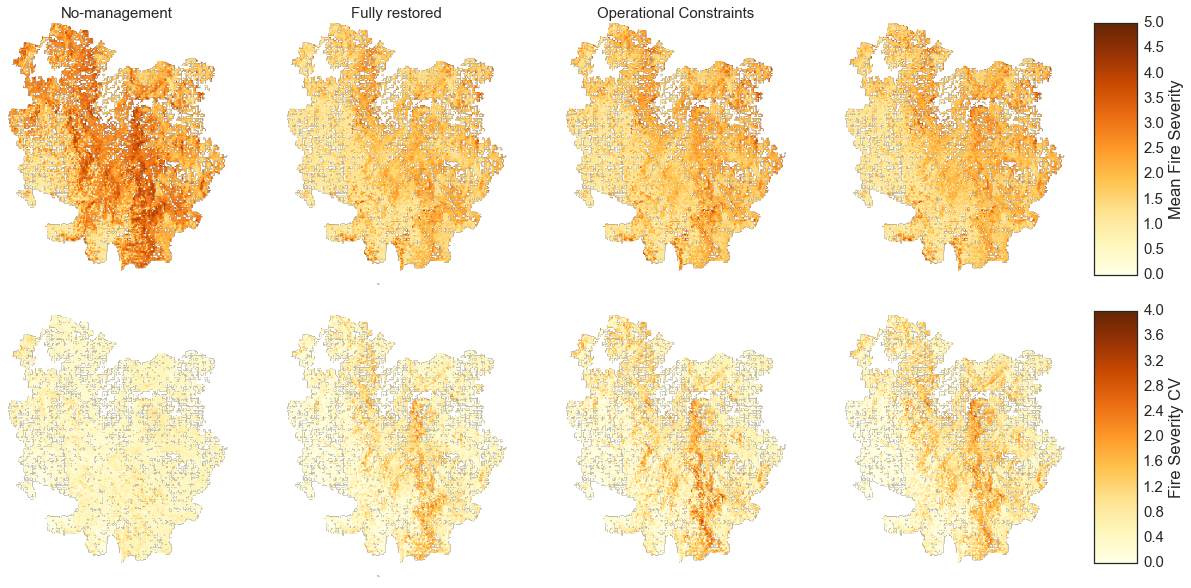

In [705]:
# Plot our hard earned severity raster
f,((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize =(20,10))
plt.subplots_adjust(wspace = 0, hspace = 0.1)

sevMapS = ax1.imshow(sevMapsLowP[1][idealizedsimNames[1]], 
                     cmap = 'YlOrBr', vmin = 0, vmax = 5)
sevMapSTRx = ax2.imshow(sevMapsLowP[2][idealizedsimNames[2]], 
                        cmap = 'YlOrBr', vmin = 0, vmax = 5)
sevMapOpcon = ax3.imshow(opconBurnSev[0][opconsimNames[0]], 
                         cmap = 'YlOrBr', vmin = 0, vmax = 5)
sevMapOpconPriority = ax4.imshow(opconBurnSev[1][opconsimNames[1]], 
                         cmap = 'YlOrBr', vmin = 0, vmax = 5)


sevMapSCV = ax5.imshow(sevVarMapsLowP[1][idealizedsimNames[1]], 
                     cmap = 'YlOrBr', vmin = 0, vmax = 4)
sevMapSTRxCV = ax6.imshow(sevVarMapsLowP[2][idealizedsimNames[2]], 
                        cmap = 'YlOrBr', vmin = 0, vmax = 4)
sevMapOpconCV = ax7.imshow(opconBurnCV[0][opconsimNames[0]], 
                         cmap = 'YlOrBr', vmin = 0, vmax = 4)
sevMapOpconPriorityCV = ax8.imshow(opconBurnCV[1][opconsimNames[1]], 
                         cmap = 'YlOrBr', vmin = 0, vmax = 4)

# Remove the axes
sns.despine()
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

# Add the color bars
cbar_ax = f.add_axes([0.90, 0.55, 0.03, 0.35])
f.colorbar(sevMapS, cax=cbar_ax, label = 'Mean Fire Severity')

cbar_axCV = f.add_axes([0.90, 0.15, 0.03, 0.35])
f.colorbar(sevMapOpconCV, cax=cbar_axCV, label = 'Fire Severity CV')

# Labels
ax1.set_title('No-management', fontsize = 15)
ax2.set_title('Fully restored', fontsize = 15)
ax3.set_title('Operational Constraints',fontsize = 15)

sns.set_style('white')
sns.set_context('notebook',font_scale=1.5)

#### At least the results make sense
it looks like we drive mean severity way down relative to the no management scenario, but don't achieve the reduction in mean severity that we see when we apply unrealistic treatments to the landscape in the fully restored scenario. 

Impacts to CV of mean severity seem to coincide with the trend we saw in the fully restored scenario, but more intense.

#### This paper will benefit from some more indepth analysis here
We did some work previously looking at the pixel by pixel mean change to fire severity due to treatment, and the pixel by pixel mean change to landscape mean NEE due to treatment. These raster-based approaches give us more than a bar plot and let us ask questions about the placement of treatments across the landscape, in the context of stochastic fire. lets look at the fire severity and CV comparisons now.

#### Keeping with the trend of the previous work, lets look at landscape NEE
and see what differences exist between the treatment scenarios

In [708]:
## Generate the data sets

idealNEE = []
idealNEECV = []

opconNEE = []
opconNEECV = []

for sim in idealizedsimNames:
    print dataDir + sim
    neerasters = NEEStack(dataDir + sim, 100)
    neeMap, neeVarMap = NEEGen(neerasters)
    neemap = {sim : neeMap}
    neevarmap = {sim : neeVarMap}

    idealNEE.append(neemap)
    idealNEECV.append(neevarmap)
    
for sim in opconsimNames:
    
    print opconDir + sim
    neerasters = NEEStack(opconDir + sim, 100)
    neeMap, neeVarMap = NEEGen(neerasters)
    neemap = {sim : neeMap}
    neevarmap = {sim : neeVarMap}

    opconNEE.append(neemap)
    opconNEECV.append(neevarmap)


idealNEE[0][idealizedsimNames[0]][idealNEE[0][idealizedsimNames[0]] == 0] = np.nan
idealNEE[1][idealizedsimNames[1]][idealNEE[1][idealizedsimNames[1]] == 0] = np.nan
idealNEE[2][idealizedsimNames[2]][idealNEE[2][idealizedsimNames[2]] == 0] = np.nan
opconNEE[0][opconsimNames[0]][opconNEE[0][opconsimNames[0]] == 0] = np.nan
opconNEE[1][opconsimNames[1]][opconNEE[1][opconsimNames[1]] == 0] = np.nan


Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/NoMgmtHistoricFireLowP
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/NoMgmtSevereFireLowP
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/ThinRxSevere_FV2
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/TreatmentPlacement/OperationalConstraint
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/TreatmentPlacement/HSFPriority


In [713]:
# Cleaning up the data and creating a single dataframe
idealNEE1 = pd.DataFrame(dict(NEE = idealNEE[0][idealizedsimNames[0]].ravel()* \
                              0.01 / ((50 * 100)) ,TRTMNT = 'No-management-Historic'))

idealNEE2 = pd.DataFrame(dict(NEE = idealNEE[1][idealizedsimNames[1]].ravel()* \
                              0.01 / ((50 * 100)) ,TRTMNT = 'No-management-Severe'))

idealNEE3 = pd.DataFrame(dict(NEE = idealNEE[2][idealizedsimNames[2]].ravel()* \
                              0.01 / ((50 * 100)) ,TRTMNT = 'Fully restored'))

opconNEE1 = pd.DataFrame(dict(NEE = opconNEE[0][opconsimNames[0]].ravel() * \
                              0.01 / ((50 * 100)) ,TRTMNT = 'Operational constraints'))

opconNEE2 = pd.DataFrame(dict(NEE = opconNEE[1][opconsimNames[1]].ravel() * \
                              0.01 / ((50 * 100)) ,TRTMNT = 'HSFPriority'))

# Concatenate our individual dataframes into a master for easy plotting etc
meanAnnualNEEs = pd.concat([idealNEE1, idealNEE2, idealNEE3, opconNEE1, opconNEE2])
meanAnnualNEEs = meanAnnualNEEs.dropna()

# Change sign convention
meanAnnualNEEs.NEE = meanAnnualNEEs.NEE * -1

#### How does operationally constraining MGMT affect landscape mean NEE?

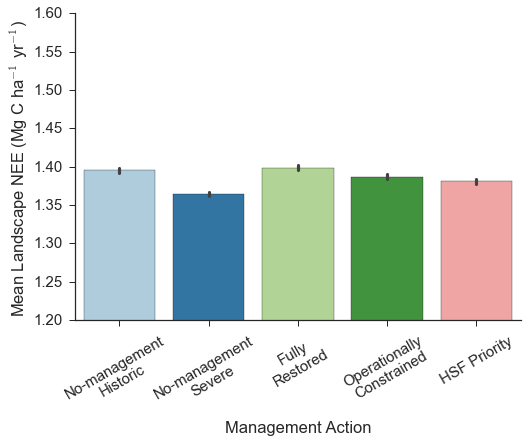

In [714]:
NEE_df = meanAnnualNEEs.groupby(['TRTMNT']).mean().reset_index()
fig, ax = plt.subplots()
sns.barplot(x = 'TRTMNT',y = 'NEE',data = meanAnnualNEEs, palette = 'Paired')
sns.despine()
plt.ylim([1.2, 1.6])
plt.ylabel('Mean Landscape NEE (Mg C ha$^{-1}$ yr$^{-1}$)')
plt.xlabel('Management Action')
plt.legend(title = 'Fire Weather')
ax.set_xticklabels(['No-management\nHistoric','No-management\nSevere',
                    'Fully\nRestored','Operationally\nConstrained', 'HSF Priority'], rotation = 30)
sns.set_context('notebook', font_scale=1.5)
plt.savefig('meanAnnualNEE_opcon.tif')


#### Similar to the work above, lets look at spatial patterns
While it would be bad ass to check out NECB spatially ... that might take a bit of effort, more than I want to spend this moment. NEE however is cake, and we've done it before. Lets check out how treatment affected the trajectory and magnitude of change in NEE spatially. -- I need to think about how to employ this, space holder for the time being.

#### We should look at C efflux from fire and management next
so we'll leverage the previously written code to dive into the thin logs (for the C removed via thinning and burning) and the Century output to grab the wildfire C efflux data.

In [33]:
thinOnlyMapsLowP = []
thinOnlyVarMapsLowP = []
thinOnlyCountMapsLowP = []

thinRxMapsLowP = []
thinRxVarMapsLowP = []
thinRxCountMapsLowP = []

idealizedsimNames = ['ThinRxSevere_FV2']
opconsimNames = ['OperationalConstraint']

for sim in idealizedsimNames + opconsimNames:
    if sim == 'OperationalConstraint':
        thisdir = opconDir
    else:
        thisdir = dataDir
    print thisdir + sim
    
    thinrasters,thinrastersTO,thinrastersRX = THINStack(thisdir + sim, 100)
    
    thinOnlyCOUNT, thinOnlySUM, thinOnlyVAR = THINGen(thinrastersTO)
    thinOmap = {sim : thinOnlySUM}
    thinOvarmap = {sim : thinOnlyVAR}
    thinOcountmap = {sim : thinOnlyCOUNT}

    thinRxCOUNT, thinRxSUM, thinRxVAR = THINGen(thinrastersRX)
    thinRxmap = {sim : thinRxSUM}
    thinRxvarmap = {sim : thinRxVAR}
    thinRxcountmap = {sim : thinRxCOUNT}
    
    # list of dicts for all Thin Only removal
    thinOnlyMapsLowP.append(thinOmap)
    thinOnlyVarMapsLowP.append(thinOvarmap)
    thinOnlyCountMapsLowP.append(thinOcountmap)

    # list of dicts for MOST Rx Fire removal
    thinRxMapsLowP.append(thinRxmap)
    thinRxVarMapsLowP.append(thinRxvarmap)
    thinRxCountMapsLowP.append(thinRxcountmap)

Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/ThinRxSevere_FV2
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/TreatmentPlacement/OperationalConstraint


#### This should be displayed as a % reduction
in the biomass that we are able to remove due to operational contraints, relative to the 'idealized ... full restoration' landscape. Something here is wonky -- need to double check the code that aggregated the thin rasters, the values look too high.

<matplotlib.colorbar.Colorbar instance at 0x00000001E0089B08>

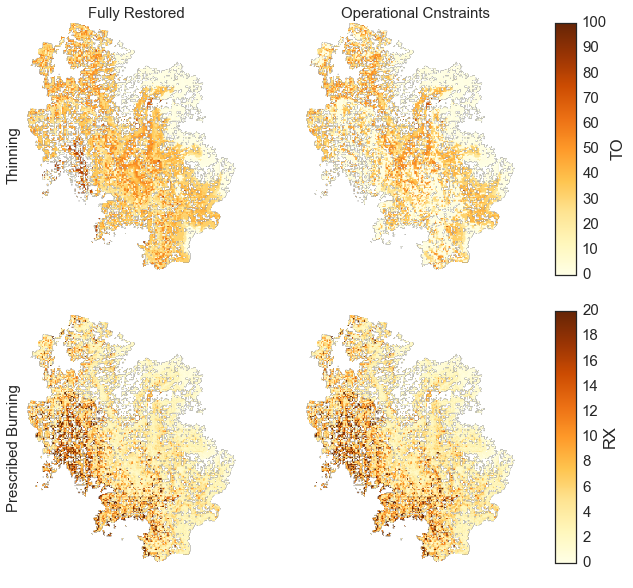

In [34]:
thinOnlyMapsLowP[0][idealizedsimNames[0]][thinOnlyMapsLowP[0][idealizedsimNames[0]] == 0] = np.nan
thinOnlyMapsLowP[1][opconsimNames[0]][thinOnlyMapsLowP[1][opconsimNames[0]] == 0] = np.nan

thinRxMapsLowP[0][idealizedsimNames[0]][thinRxMapsLowP[0][idealizedsimNames[0]] == 0] = np.nan
thinRxMapsLowP[1][opconsimNames[0]][thinRxMapsLowP[1][opconsimNames[0]] == 0] = np.nan

f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize =(10,10))
plt.subplots_adjust(wspace = 0, hspace = 0.1)
axs = f.axes
sns.despine()
idx = 0
ax1.imshow(thinOnlyMapsLowP[0][idealizedsimNames[0]] * ((0.01) / 50), cmap = 'YlOrBr', vmin = 0, vmax = 100)
cbarmapTO = ax2.imshow(thinOnlyMapsLowP[1][opconsimNames[0]] * ((0.01) / 50), cmap = 'YlOrBr', vmin = 0, vmax = 100)

ax3.imshow(thinRxMapsLowP[0][idealizedsimNames[0]] * ((0.01) / 50), cmap = 'YlOrBr', vmin = 0, vmax = 20)
cbarmapRX = ax4.imshow(thinRxMapsLowP[1][opconsimNames[0]] * ((0.01) / 50), cmap = 'YlOrBr', vmin = 0, vmax = 20)

ax1.set_title('Fully Restored', fontsize = 15)
ax2.set_title('Operational Cnstraints', fontsize = 15)
ax1.set_ylabel('Thinning', fontsize = 15)
ax3.set_ylabel('Prescribed Burning', fontsize = 15)

for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
cbar_ax = f.add_axes([0.9, 0.15, 0.03, 0.35])

# Add the color bars
cbar_ax = f.add_axes([0.90, 0.55, 0.03, 0.35])
f.colorbar(cbarmapTO, cax=cbar_ax, label = 'TO')

cbar_axCV = f.add_axes([0.90, 0.15, 0.03, 0.35])
f.colorbar(cbarmapRX, cax=cbar_axCV, label = 'RX')


#### Reading in the thin logs
will give us a means to create wildfire + Rx fire emission boxplots by treatment

In [35]:
idealizedTlog = genThinLog(dataDir, ['ThinRxSevere_FV2'], 'log.csv')
openTlog = genThinLog(opconDir, ['OperationalConstraint'], 'log.csv')

Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/ThinRxSevere_FV2
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/TreatmentPlacement/OperationalConstraint


In [36]:
test = openTlog.groupby(['SIM','Prescription','REP']).sum().reset_index()

In [37]:
meanOfReps = test.groupby(['SIM','Prescription']).mean().reset_index()
meanOfReps['activeArea'] = 45256

meanOfReps['AreaWeightedC_Reduc'] = (meanOfReps.MgBiomassRemoved / meanOfReps['activeArea'])*.5
hack = test.groupby('REP').sum().reset_index()
hack['activeArea'] = 45256
hack['AreaWeightedC_Reduc'] = (hack.MgBiomassRemoved / hack['activeArea'])*.5

In [38]:
rxEmissions = meanOfReps.loc[meanOfReps.Prescription != 'ThinOnly'].AreaWeightedC_Reduc.sum()
groupedRep = totSims.groupby(['Sim','rep']).sum().reset_index()
groupedRep['RxAdjustedEmissions'] = groupedRep.FireCEffluxw
groupedRep.RxAdjustedEmissions.loc[groupedRep.Sim == 'Opcon'] = \
    groupedRep.RxAdjustedEmissions[groupedRep.Sim == 'Opcon'] + hack.AreaWeightedC_Reduc

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [39]:
totSims.RxAdjustedEmissions[totSims.Sim == 'Opcon'].size

AttributeError: 'DataFrame' object has no attribute 'RxAdjustedEmissions'

### Lets calculate the probability of high severity fire
for our OpCon parameterized landscape so we can build up the treatment prioritization management units. There's still a lot of run of the mill output to work up, but this is more important for the time being.

In [716]:
sevMapsLowP = []
sevVarMapsLowP = []
totalFireMaps = []
totalHSFireMaps = []
pHS_FireMaps = []

for sim in opconsimNames:
    print dataDir + sim
    sevrasters = severityStack(opconDir + sim, 100)
    meansev, varsev, totalFires, totalHSFires, pHS_Fire = severityPGen(sevrasters)    
    sevmap = {sim : meansev}
    varmap = {sim : varsev}
    tfires = {sim : totalFires}
    thsfires = {sim : totalHSFires}
    hsfirep = {sim : pHS_Fire}

    sevMapsLowP.append(sevmap)
    sevVarMapsLowP.append(varmap)
    totalFireMaps.append(tfires)
    totalHSFireMaps.append(thsfires)
    pHS_FireMaps.append(hsfirep)


Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/OperationalConstraint
Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/HSFPriority


#### Plot the result of the pHS Fire like we did above

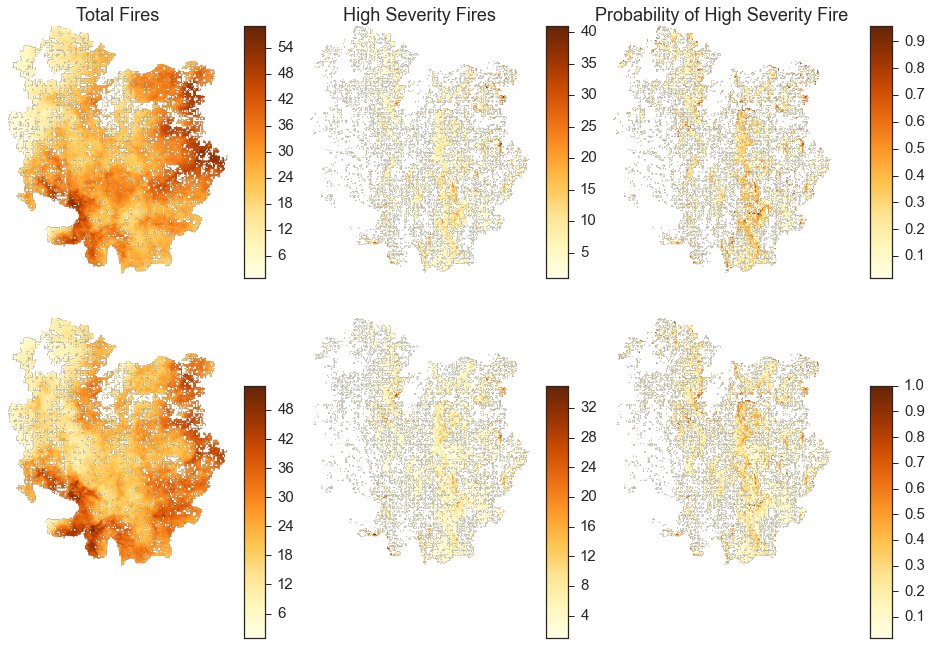

In [717]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize =(15,10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.1)
firesTotal = ax1.imshow(totalFireMaps[0][opconsimNames[0]], cmap = 'YlOrBr')
HSfiresTotal = ax2.imshow(totalHSFireMaps[0][opconsimNames[0]], cmap = 'YlOrBr')
HSFire_Probability = ax3.imshow(pHS_FireMaps[0][opconsimNames[0]], cmap = 'YlOrBr')

firesTotalp = ax4.imshow(totalFireMaps[1][opconsimNames[1]], cmap = 'YlOrBr')
HSfiresTotalp = ax5.imshow(totalHSFireMaps[1][opconsimNames[1]], cmap = 'YlOrBr')
HSFire_Probabilityp = ax6.imshow(pHS_FireMaps[1][opconsimNames[1]], cmap = 'YlOrBr')



# Remove the axes
sns.despine()
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

# Add the color bars
cbar_ax1 = f.add_axes([0.35, 0.55, 0.02, 0.35])
f.colorbar(firesTotal, cax=cbar_ax1)

cbar_ax2 = f.add_axes([0.63, 0.55, 0.02, 0.35])
f.colorbar(HSfiresTotal, cax=cbar_ax2)

cbar_ax3 = f.add_axes([0.93, 0.55, 0.02, 0.35])
f.colorbar(HSFire_Probability, cax=cbar_ax3)

cbar_ax4 = f.add_axes([0.35, 0.05, 0.02, 0.35])
f.colorbar(firesTotalp, cax=cbar_ax4)

cbar_ax5 = f.add_axes([0.63, 0.05, 0.02, 0.35])
f.colorbar(HSfiresTotalp, cax=cbar_ax5)

cbar_ax6 = f.add_axes([0.93, 0.05, 0.02, 0.35])
f.colorbar(HSFire_Probabilityp, cax=cbar_ax6)


ax1.set_title('Total Fires')
ax2.set_title('High Severity Fires')
ax3.set_title('Probability of High Severity Fire')

sns.set_style('white')
sns.set_context('notebook',font_scale=1.5)
plt.savefig('OpCon_FireCountsAndProbability.tif')

### Thought process for high severity prioritization
We want to look at how this probability of high severity raster relates to our existing management units. First, we need to reclass the pHSF raster into some sort of binned integer units. Were looking at a continuous raster layer here and really we need to think about discretizing the landscape into treatable units. Lets divide the pHSF raster into 5 bins, of equal binwidth, and calculate some stats on each bin by management unit.

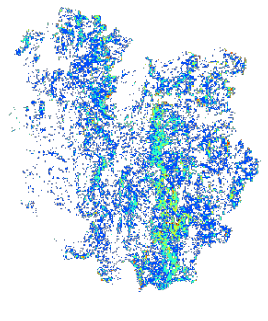

In [98]:
# manual reclass of the pHSF raster
pHSF = pHS_FireMaps[0][opconsimNames[0]]
pHSF[pHSF > 0.8]= 5
pHSF[(pHSF > 0.6) & (pHSF <= 0.8)]= 4
pHSF[(pHSF > 0.4) & (pHSF <= 0.6)]= 3
pHSF[(pHSF > 0.2) & (pHSF <= 0.4)]= 2
pHSF[pHSF <= 0.2] = 1


plotRaster(pHSF, vmin = 0, vmax = 5,  cmap = 'jet')

#### Now that we have our discretized probability of high severity fire raster
we can think about integrating it with the existing operationally constrained management unit raster. Functionally, we want to take the existing management units, and break them into prioritized chunks, or in this case other management units. Lets look at the opcon management unit raster along side our discretized high severity fire raster.

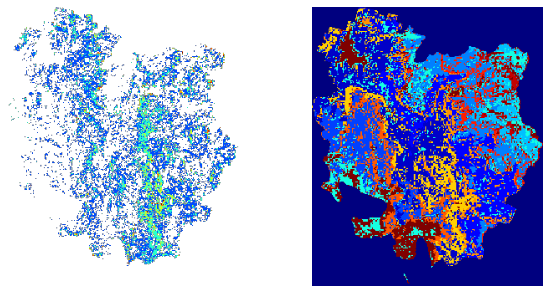

In [106]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
plotRaster(pHSF, ax1, vmin = 0, vmax = 5, cmap = 'jet')
plotRaster(operMgmt, ax2, cmap = 'jet')

#### So we want to divide each of these units into 5 separate units
Thats a lot of units, and keeping track of them is going to become a hassle. The current management unit numbers are 0 (inactive), 1 - 6, and 11- 16. Our previous solution was simply to add 10 to each existing management unit. Now we need something craftier. 

In [173]:
#Start by cheating our way into some copies of the pHSF and opconMgmt layers
pHSFc = pHSF + 0
operMgmtc = operMgmt * 10
pHSFc[np.isnan(pHSFc)] = 0
operMgmtc = operMgmtc + pHSFc
operMgmtc[operMgmt == 0] = 0
operMgmtc[operMgmtc == 0].size

36745

#### Thats a lot of managment units -- but it works
And its actually not too crafty, but its simplicity is really extra super neat. The resulting units tell us about the previous treatment, and the % chance of HS wildfire. For example, new unit 10 and new unit 13 are both old unit 1 (mechanically thinnable PPINE), but they differ in that new unit 10 has a pHSF < .2 whereas 13 falls into the 0.4 - 0,6 range. Now we know that PPINE 13 should take priority over PPINE 12, 11, and 10.

In [629]:
np.unique(operMgmtc)

array([   0.,   10.,   11.,   12.,   13.,   20.,   21.,   22.,   23.,
         24.,   30.,   31.,   32.,   33.,   40.,   41.,   42.,   43.,
         50.,   51.,   52.,   53.,   60.,   61.,   62.,   63.,   64.,
        110.,  111.,  112.,  113.,  114.,  120.,  121.,  122.,  123.,
        124.,  130.,  131.,  132.,  133.,  134.,  140.,  141.,  142.,
        143.,  144.,  150.,  151.,  152.,  153.,  154.,  155.,  160.,
        161.,  162.,  163.,  164.,  165.])

#### Finally export the management unit raster in the same format as the OpCon raster
and for some piece of mind, import the new raster and visualize it

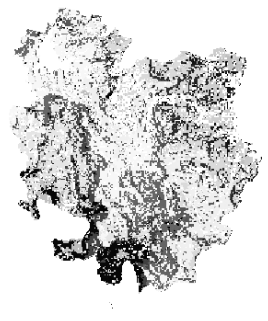

In [635]:
saveAsGeoTiff('Z:\Dan K\DinkeyCreek\LANDIS_RUNS\OpConMgmt.tif', 
              operMgmtc, 'Z:\Dan K\DinkeyCreek\LANDIS_RUNS\OpConMgmt_priority.tif', 5070)
OpConPriority = importRaster('Z:\Dan K\DinkeyCreek\LANDIS_RUNS\OpConMgmt_priority.tif')
plotRaster(OpConPriority)

#### Now ... the hard part, we need to actually think of a way to implement this in some reasonable way.
The problem here is that in the treatment files, we treat some percentage of an area each year, then for the prescribed fire, repeat based on the historic return interval for the dominant veg type. I think we're going to have to modify the percentages here based on the relative size of each new mgmt unit -- a huge pain. Lets start by looking at each operationally constrained management unit's area. The area we actually care about is the active area within each management unit -- initial communities and ecoregions can further constrain whats active and whats not. Lets read in the Ecoregion file for Dinkey and add all inactive cells to the mask.

47732

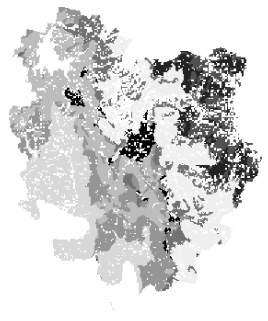

In [174]:
ecoregions = 'Z:\Dan K\DinkeyCreek\LANDIS_RUNS\Dinkey_Ecoregions.tif'
eco = importRaster(ecoregions)
plotRaster(eco)
operMgmtc[eco == 0] = 0
operMgmtc[operMgmtc == 0].size

#### Now we can generate some unique area statistics
and create areas for each original management unit by severity class

In [453]:
unitList = []
unitArea = []
for unit in np.unique(operMgmtc[operMgmtc != 0]):
    unitA = operMgmtc[operMgmtc == unit].size
    unitList.append(unit)
    unitArea.append(unitA)
    
mgmtAreas = pd.DataFrame(dict(ManagementUnit = unitList, Area = unitArea, 
                              Biome = 'forest', Treatment = 'fire', 
                              pHSF = 0, pHSF_N = 0))


#### Create an associated label system for each management unit
Just to simplify the logic creation for assigning treatments in the leaf biomass harvest extension.

In [455]:
# First, convert the new managmenet unit numbers to their base values
# most easily done by division by 10, followed by stripping the decimal.
# These values then relate to the base biome, and the operational constraint
# with regard to the limitation of high slopes developed above.
mgmtList = map(int,mgmtAreas.ManagementUnit / 10)
mgmtAreas['OpconUnit'] = mgmtList

# Create a quick dictionary for our assignments
biomeDict = {3:'Ponderosa',1:'Mcon-Pine',
             2:'Mcon-Fir',4:'Red Fir',
             5:'Subalpine',6:'Not Managed'}

# And a quick pHSF dictionary as well
pHSFDict = {0:'None',1:'Low',2:'Medium',
            3:'High',4:'Very High',5:'Extreme'}

# Now we can populate our biome table
for unit in np.arange(1,7,1):
    print unit, biomeDict[unit]
    mgmtAreas['Biome'].loc[mgmtAreas.OpconUnit == unit] = biomeDict[unit]
    mgmtAreas['Biome'].loc[mgmtAreas.OpconUnit == (unit + 10)] = biomeDict[unit]
    
# And the treatment table
mgmtAreas['Treatment'].loc[mgmtAreas.OpconUnit < 7] = 'Thin and burn'
mgmtAreas['Treatment'].loc[mgmtAreas.OpconUnit > 7] = 'Burn only'

# And the pHSF table
for HSFi in np.arange(0,6,1):
    mgmtAreas['pHSF'].loc[mgmtAreas.ManagementUnit - \
                          mgmtAreas.OpconUnit * 10 == HSFi] = pHSFDict[HSFi]
    mgmtAreas['pHSF_N'].loc[mgmtAreas.ManagementUnit - \
                          mgmtAreas.OpconUnit * 10 == HSFi] = HSFi


1 Mcon-Pine
2 Mcon-Fir
3 Ponderosa
4 Red Fir
5 Subalpine
6 Not Managed


#### Now we can create some visuals to describe the distribution of land
within our management units that fall into each of the 6 pHSF classes. First a raw barplot containing all the data and absolute areas.

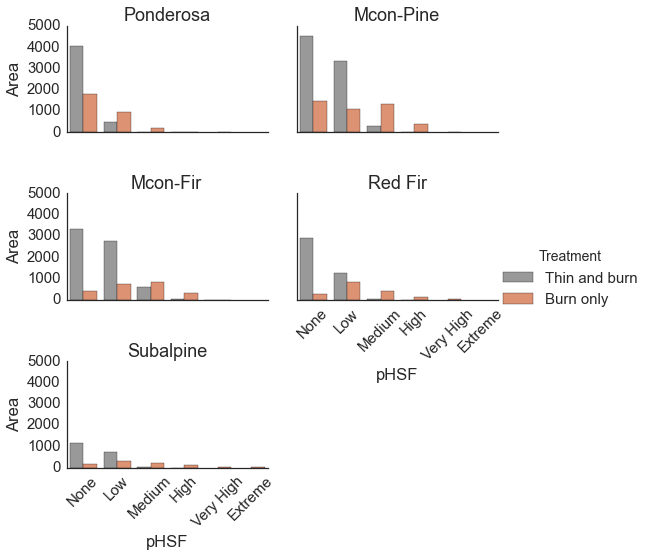

In [456]:
#Organize the plot by elevation
elevOrder = ['Ponderosa','Mcon-Pine','Mcon-Fir',
                    'Red Fir','Subalpine']

g = sns.factorplot(x = 'pHSF', y = "Area", col="Biome", col_wrap=2,
                   kind = 'bar', hue = 'Treatment', palette = ['#999999','#ef8a62'],
                   data=mgmtAreas, col_order = elevOrder, size=2.5, aspect=1.5)

g.set_xticklabels(rotation = 45)

for ax, title in zip(g.axes.flat, elevOrder):
    ax.set_title(title)

#### I'm interested in seeing what percent of each management unit
falls into each severity class by management option, so we have to calculate some percentages. Sort of an annoying task if were going to build a dataframe for easy plotting. 

In [457]:
biomeT = mgmtAreas.groupby(['Biome']).sum().reset_index()
short =  mgmtAreas.groupby(['Biome', 'Treatment','pHSF']).sum().reset_index()

percents = []
biomes = []
treatments = []
sevs = []
for biome in np.unique(quick.Biome):
    thisB = short[short.Biome == biome]
    for treatment in np.unique(short.Treatment):
        thisBT = thisB[thisB.Treatment == treatment]
        for sev in np.unique(thisBT.pHSF):
            biomes.append(biome)
            treatments.append(treatment)
            percents.append(np.float(thisBT.Area[short.pHSF == sev].iloc[0])
                            / np.float(quick.Area[quick.Biome == biome].iloc[0]))
            sevs.append(sev)
percentA = pd.DataFrame(dict(Biome = biomes, Percent = percents, 
                             Treatment = treatments, pHSF = sevs))

#### First off, what percent of the land area by biome is available to thin
and what areais limited to prescribed fire?

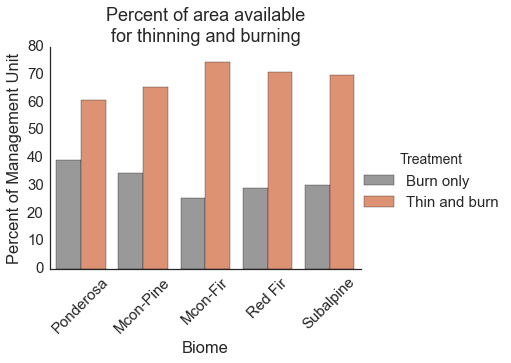

In [458]:
percentSum = percentA.groupby(['Biome','Treatment']).sum().reset_index()
percentSum.Percent = percentSum.Percent * 100
elevOrder = ['Ponderosa','Mcon-Pine','Mcon-Fir',
                    'Red Fir','Subalpine']

g = sns.factorplot(x = 'Biome', y = "Percent",
                   kind = 'bar', hue = 'Treatment', palette = ['#999999','#ef8a62'],
                   data=percentSum, order = elevOrder, size=4.3, aspect=1.3)

g.set_xticklabels(rotation = 45)
g.set_ylabels('Percent of Management Unit')
sns.plt.title('Percent of area available \nfor thinning and burning')

#### How does this trend further berak up by severity class?
We would expect decreasing percentages of the landscape as the pHSF increases, and probably expect some patterns with elevation as well. It would be neat to look at this by biomass, or some other fuels dictating variable

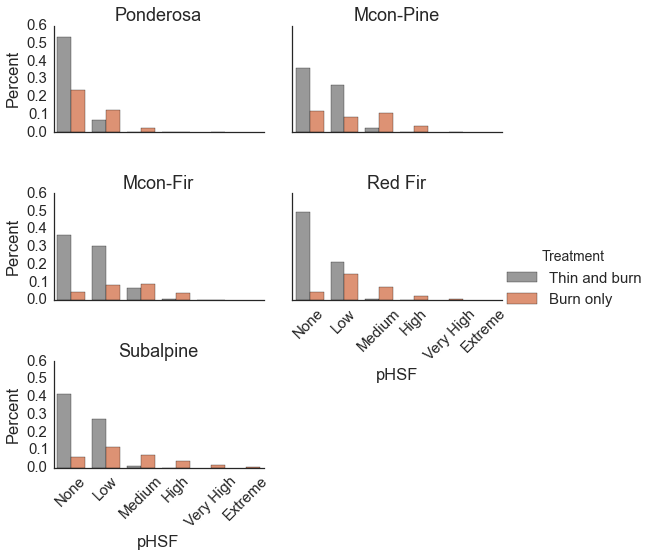

In [459]:
elevOrder = ['Ponderosa','Mcon-Pine','Mcon-Fir',
                    'Red Fir','Subalpine']

g = sns.factorplot(x = 'pHSF', y = "Percent", col="Biome", col_wrap=2,
                   kind = 'bar', hue = 'Treatment', palette = ['#999999','#ef8a62'],
                   data=percentA, order = ['None','Low','Medium','High','Very High','Extreme'],
                   hue_order = ['Thin and burn','Burn only'], col_order = elevOrder, size=2.5, aspect=1.5)

g.set_xticklabels(rotation = 45)

for ax, title in zip(g.axes.flat, elevOrder):
    ax.set_title(title)

#### Looks like there is an interesting pattern here
and that while the majority of the landscape is likely to experience no to very few high severity fires, these distributions vary by biome. Further it looks like the areas that are most likely to experience high severity fire are unavailable to thin mechanically. Theres some neat stuff to unpack here but to get the ball rolling on the simulations the next step is to find out what percent of each unit we're talking if we add up everything with medium severity and higher for instance.

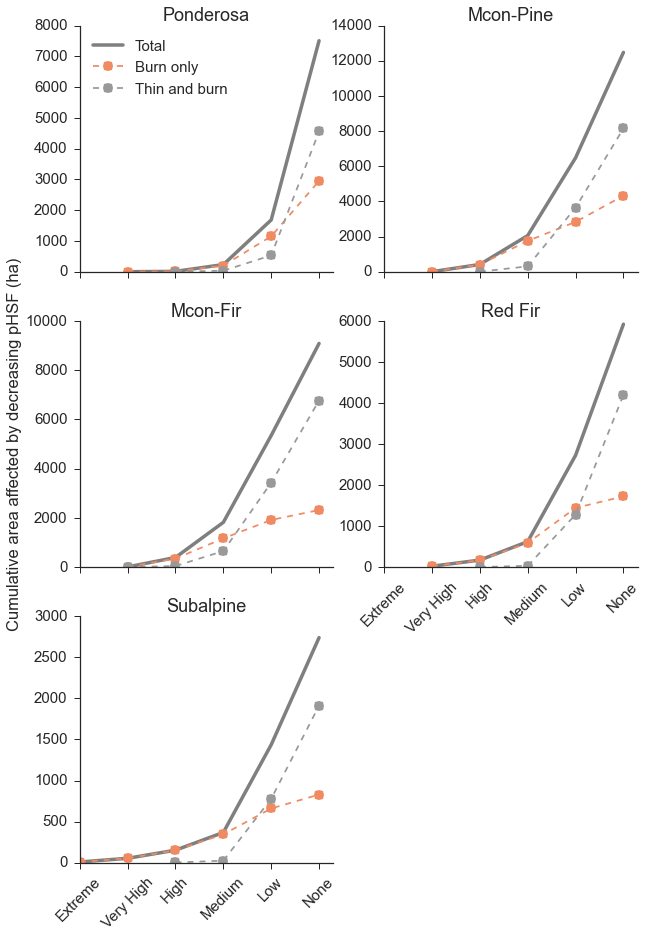

In [589]:
# Sort the dataframe so we can accumulate land area by decreasing pHSF
sortedpHSF = mgmtAreas.sort_values(by=['Biome','pHSF_N'], ascending=[False, False]).reset_index()

# Setup the figure
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize =(10,15))
sns.set_style('ticks')
idx = 0
axs = f.axes

# Iterate over the biomes in the df according to the previously used elevation ordering
for biome in elevOrder:
    
    # set the correct axis
    ax = axs[idx]
    
    # Subset the data by treatment and biomes, take some sums and reorder as necessary
    biomei = sortedpHSF[sortedpHSF.Biome == biome]

    biomeiBO = biomei[biomei.Treatment == 'Burn only'].reset_index()
    biomeiTB = biomei[biomei.Treatment == 'Thin and burn'].reset_index()

    biomeiG = biomei.groupby('pHSF_N').sum().reset_index()
    biomeiG = biomeiG.sort_values(by=['pHSF_N'], ascending=[False]).reset_index()

    # Cumulative sum by decreasing pHSF
    biomeiG['totaledArea'] = biomeiG.Area.cumsum()
    biomeiBO['totaledArea'] = biomeiBO.Area.cumsum()
    biomeiTB['totaledArea'] = biomeiTB.Area.cumsum()

    # Simple line plots
    ax.plot(biomeiG.pHSF_N, biomeiG.totaledArea, c = 'k', 
        lw = 3.5, alpha = 0.5)
    ax.plot(biomeiBO.pHSF_N, biomeiBO.totaledArea, 
             c = '#ef8a62', ls = '--', marker = 'o', ms = 10)
    ax.plot(biomeiTB.pHSF_N, biomeiTB.totaledArea, 
             c = '#999999', ls = '--', marker = 'o', ms = 10)
    ax.set_xlim([5,-.3])
    ax.set_xticks([5,4,3,2,1,0])
    ax.set_title(biome)
    ax.set_xticklabels('')

    idx = idx + 1


for ax in f.axes[3:5]:
    ax.set_xticklabels(['Extreme','Very High','High','Medium','Low','None'], rotation = 45)
ax1.legend(['Total','Burn only', 'Thin and burn'], loc = 0)
ax3.set_ylabel('Cumulative area affected by decreasing pHSF (ha)')
# Remove the empty axes
f.delaxes(ax6)
sns.despine()


#### Now that we have the data chopped up this way
and its apparent that we most likely can treat everything with a 'medium' probability of HSF and below without going over our practical treatment limits, we need to calculate those areas so we can create an actual treatment plan.

In [622]:
thinSorted = sortedpHSF[sortedpHSF.Treatment == 'Thin and burn']
for biome in elevOrder:
    Cbiome = thinSorted[thinSorted.Biome == biome]
    HSsum = np.float(Cbiome[Cbiome.pHSF_N > 1].Area.sum())
    MUtot = np.float(Cbiome.Area.sum())
    percent = (HSsum / MUtot) * 100
    print biome, HSsum, MUtot, percent

Ponderosa 33.0 4558.0 0.724001755156
Mcon-Pine 306.0 8150.0 3.75460122699
Mcon-Fir 653.0 6767.0 9.64977094724
Red Fir 33.0 4197.0 0.786275911365
Subalpine 23.0 1912.0 1.20292887029


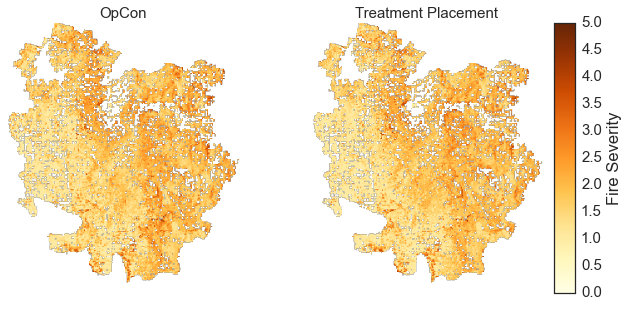

In [735]:
# Plot our hard earned severity raster
f,((ax1, ax2)) = plt.subplots(1,2, figsize =(10,5))
plt.subplots_adjust(wspace = 0.2, hspace = 0.1)

sevMapOpcon = ax1.imshow(opconBurnSev[0][opconsimNames[0]], 
                         cmap = 'YlOrBr', vmin = 0, vmax = 5)
sevMapOpconPriority = ax2.imshow(opconBurnSev[1][opconsimNames[1]], 
                         cmap = 'YlOrBr', vmin = 0, vmax = 5)


# Remove the axes
sns.despine()
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

# Add the color bars
cbar_axCV = f.add_axes([0.90, 0.15, 0.03, 0.75])
f.colorbar(sevMapOpconPriority, cax=cbar_axCV, label = 'Fire Severity')

# Labels
ax1.set_title('OpCon', fontsize = 15)
ax2.set_title('Treatment Placement', fontsize = 15)

sns.set_style('white')
sns.set_context('notebook',font_scale=1.5)

<matplotlib.colorbar.Colorbar instance at 0x00000004119BF148>

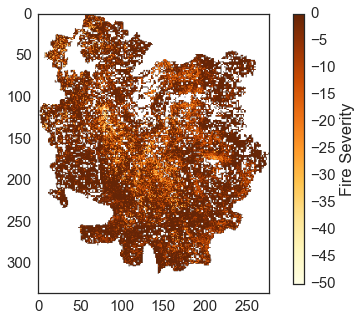

In [754]:
percentDiff = (opconBurnSev[0][opconsimNames[0]] - \
               opconBurnSev[1][opconsimNames[1]]) / \
                opconBurnSev[1][opconsimNames[1]] * 100
    
f,(ax1) = plt.subplots(1,1, figsize =(5,5))
plt.subplots_adjust(wspace = 0.2, hspace = 0.1)

sevMapOpcon = ax1.imshow(percentDiff, 
                         cmap = 'YlOrBr', vmin = -50, vmax =0)
cbar_axCV = f.add_axes([0.90, 0.15, 0.03, 0.75])
f.colorbar(sevMapOpcon, cax=cbar_axCV, label = 'Fire Severity')



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000003EF10E6D8>]], dtype=object)

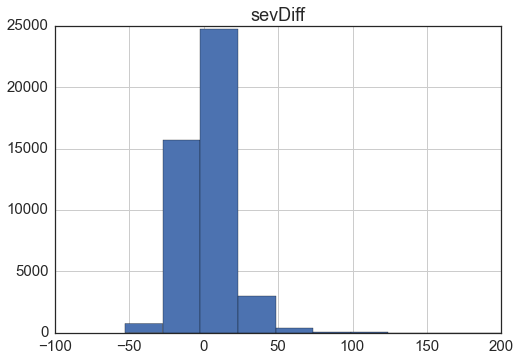

In [759]:
check = pd.DataFrame(dict(sevDiff = percentDiff.ravel()))
check.dropna().hist()

<matplotlib.colorbar.Colorbar instance at 0x00000000C41B88C8>

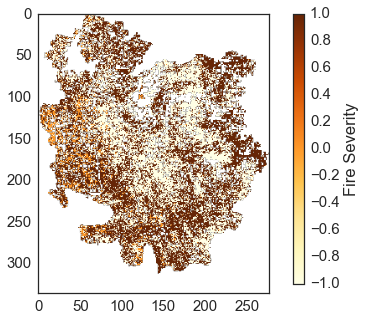

In [753]:
percentDiff[percentDiff < 0] = -1
percentDiff[percentDiff > 0] = 1
f,(ax1) = plt.subplots(1,1, figsize =(5,5))
plt.subplots_adjust(wspace = 0.2, hspace = 0.1)

sevMapOpcon = ax1.imshow(percentDiff, 
                         cmap = 'YlOrBr', vmin = -1, vmax =1)
cbar_axCV = f.add_axes([0.90, 0.15, 0.03, 0.75])
f.colorbar(sevMapOpcon, cax=cbar_axCV, label = 'Fire Severity')
